This notebook gives the basic steps in order to perform an azimuthal integration, including pixel splitting, of a scattering pattern recorded with the DSSC detector which has hexagonal spahed pixels.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

# DSSC geometry

From the quadrants position and the position of the modules inside each quadrants we compute a DSSC geometry

In [2]:
from extra_data import open_run
from extra_data.components import DSSC1M
from extra_geom import DSSC_1MGeometry

quad_pos = [(-122.21101449000001, 2.17217391),
    (-124.4, -118.94881159),
    (1.32336232, -120.39306931),
    (3.1934492800000003, 0.80901765)]
geom_file = "/gpfs/exfel/exp/SCS/201901/p002212/usr/Shared/Training_UP-2719/geometry/dssc_geom_AS_aug20.h5"
geom = DSSC_1MGeometry.from_h5_file_and_quad_positions(geom_file, quad_pos)

We then give this information to pyFAI by creating a detector object from the individuals 6 corner position of each one million pixels.

In [3]:
import pyFAI.azimuthalIntegrator
import pyFAI.detectors

dssc = pyFAI.detectors.Detector(204e-6, 236e-6)
dssc.aliases = ["DSSC1M"]
dssc.shape = (16*128, 512)
dssc.mask = np.zeros((16*128, 512))
dssc.IS_CONTIGUOUS = False
dssc.IS_FLAT = True
dssc.set_pixel_corners(geom.to_distortion_array())

_, (center_y, center_x) = geom.position_modules_fast(np.zeros((16, 128, 512)))
px_w, px_h = geom._pixel_shape
ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(detector = dssc, poni1=center_y * px_h, poni2=center_x * px_w)

# Load the test data

We then load some test data to test the azimuthal integration.

In [4]:
import xarray as xr
path = '/gpfs/exfel/exp/SCS/202022/p002711/usr/processed_runs/r97'
data = xr.open_mfdataset(path + '/*.h5', parallel=True, join='inner')

data

<xarray.Dataset>
Dimensions:            (bin_nrj: 1, module: 16, pp: 1, pulse_slot: 2700, sa1_pId: 200, x: 512, y: 128)
Coordinates:
  * bin_nrj            (bin_nrj) float64 780.0
  * module             (module) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * pp                 (pp) object 'unpumped'
  * sa1_pId            (sa1_pId) int64 600 604 608 612 ... 1384 1388 1392 1396
Dimensions without coordinates: pulse_slot, x, y
Data variables:
    DSSC               (pp, bin_nrj, module, y, x) float64 dask.array<chunksize=(1, 1, 1, 128, 512), meta=np.ndarray>
    SCS_SA1            (module, bin_nrj, sa1_pId) float64 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    SCS_SA3            (module, pp, bin_nrj) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    bunchPatternTable  (module, bin_nrj, pulse_slot) float64 dask.array<chunksize=(1, 1, 2700), meta=np.ndarray>
    nrj                (module, bin_nrj) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [5]:
img = data['DSSC'].squeeze()
img.shape

(16, 128, 512)

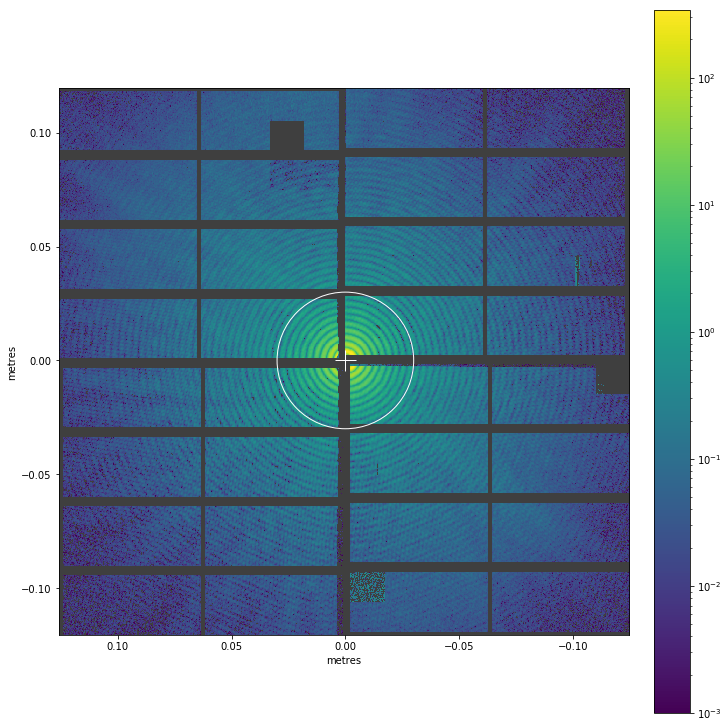

In [6]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

geom2 = geom.offset((0, 0))

ax = geom2.plot_data_fast(img, colorbar=True, norm=LogNorm(), vmin=1e-3, axis_units='m')
ax.add_patch(Circle((0, 0), radius=0.03, fill=False, color='white'))

In [7]:
joined = img.values.reshape(16*128, 512)

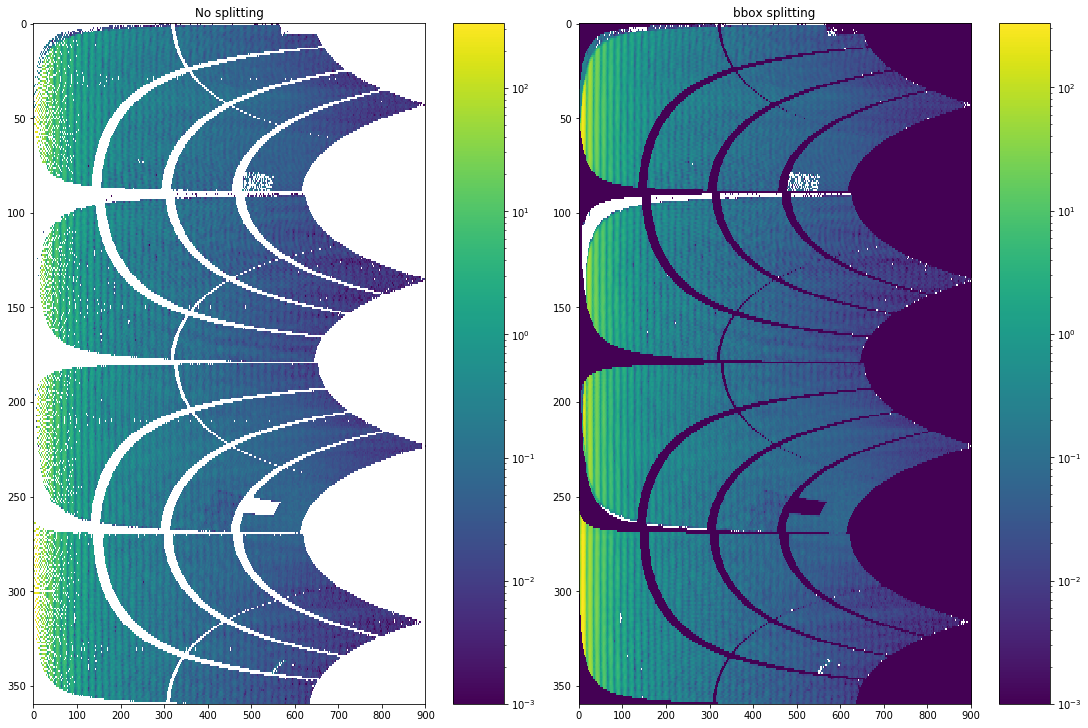

In [8]:
cake_bbox, q, chi = ai.integrate2d(
    joined,
    npt_rad=900,
    unit='r_mm',
    correctSolidAngle=False,
    method="bbox",
)

cake_nosplitting, q, chi = ai.integrate2d(
    joined,
    npt_rad=900,
    unit='r_mm',
    correctSolidAngle=False,
    method="no",
)


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 10))

im0 = ax0.imshow(cake_nosplitting, aspect='auto', norm=LogNorm(), vmin=1e-3)
ax0.set_title('No splitting')
cbar = fig.colorbar(im0, ax=ax0)

im1 = ax1.imshow(cake_bbox, aspect='auto', norm=LogNorm(), vmin=1e-3)
ax1.set_title('bbox splitting')
cbar = fig.colorbar(im1, ax=ax1)

We can confirm that pixel splitting improves the data representation in the low-q range.

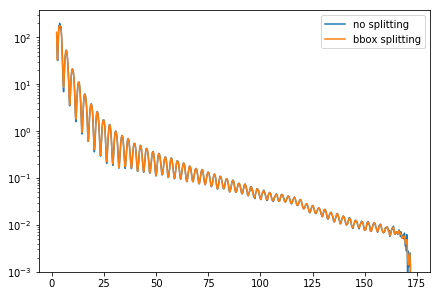

In [9]:
rint_no, I_no = ai.integrate1d(
    joined,
    npt=900,
    unit='r_mm',
    method='no'
)

rint_bbox, I_bbox = ai.integrate1d(
    joined,
    npt=900,
    unit='r_mm',
    method='bbox'
)

plt.figure()
plt.semilogy(rint_no, I_no, label='no splitting')
plt.semilogy(rint_bbox, I_bbox, label='bbox splitting')
plt.ylim(bottom=1e-3)
plt.legend()